In [8]:
# !curl https://docs.google.com/uc?id=0B3X9GlR6EmbnWksyTEtCM0VfaFE&export=download
# !chmod +x gdrive
# !sudo install gdrive /usr/local/bin/gdrive

In [1]:
# !gdrive download 1qOpnokPbRh6y0nCQya9El8lySMPBXauq

Downloaded 1qOpnokPbRh6y0nCQya9El8lySMPBXauq at 76.4 MB/s, total 4.8 GB


In [1]:
# !git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 72.79 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.callbacks import SaveModelCallback

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [4]:
path = Path('data')


In [5]:
path.ls()

[PosixPath('data/kansas_wheat_square.csv'),
 PosixPath('data/kansas_wheat_sq'),
 PosixPath('data/models'),
 PosixPath('data/kansas_masks_2016'),
 PosixPath('data/kansas_wheat_sq_2016'),
 PosixPath('data/kansas_masks'),
 PosixPath('data/crop_masks.csv')]

In [6]:
fnames = get_image_files(path/'kansas_wheat_sq_2016')
fnames[:3]

[PosixPath('data/kansas_wheat_sq_2016/mask_tile_4200_8100.tif'),
 PosixPath('data/kansas_wheat_sq_2016/mask_tile_18900_11100.tif'),
 PosixPath('data/kansas_wheat_sq_2016/mask_tile_19500_8400.tif')]

In [7]:
lbl_names = get_image_files(path/'kansas_masks_2016')
lbl_names[:3]

[PosixPath('data/kansas_masks_2016/tile_14400_6300.tif'),
 PosixPath('data/kansas_masks_2016/tile_7500_300.tif'),
 PosixPath('data/kansas_masks_2016/tile_14700_1800.tif')]

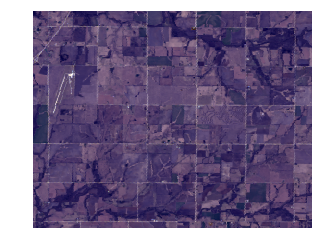

In [8]:
img_f = fnames[2]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
def get_y_fn(x): 
    return Path(str(x.parent.parent)+'/kansas_masks')/x.name[5:]

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

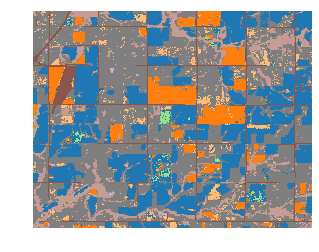

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
mask.data.unique()

tensor([  1,   4,   5,  24,  26,  27,  28,  36,  37,  58,  61, 111, 121, 122,
        123, 124, 131, 141, 143, 152, 176, 190, 195, 205, 236])

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([ 901, 1159]), tensor([[[141, 141, 141,  ...,   5,   5, 176],
          [190, 190, 190,  ...,   5,   5, 176],
          [190, 190, 190,  ...,   5,   5, 176],
          ...,
          [176, 176, 176,  ..., 141, 141, 141],
          [176, 176, 176,  ..., 141, 141, 141],
          [176, 176, 176,  ..., 141, 141, 141]]]))

In [13]:
bs,size = 8,(256,256)

In [14]:
crop_codes = ['void','wheat']

In [15]:
class WheatSegmentationLabelList(SegmentationLabelList):
    def __init__(self, items:Iterator,**kwargs):
        super().__init__(items, **kwargs)
    def open(self, fn): 
        mask = open_mask(fn)
        #corresponds to wheat
        mask.px = (mask.px == 24).float()
#         import pdb; pdb.set_trace()
        return mask

In [16]:
SegmentationItemList._label_cls = WheatSegmentationLabelList

In [17]:
src = (SegmentationItemList.from_folder(path,include='kansas_wheat_sq',extensions='.tif')
       .split_by_rand_pct(0.15)
       .label_from_func(get_y_fn, classes=crop_codes)
      )


In [18]:
warnings.filterwarnings("ignore")

In [19]:
data = (src.transform(get_transforms(flip_vert=True), tfm_y=True, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

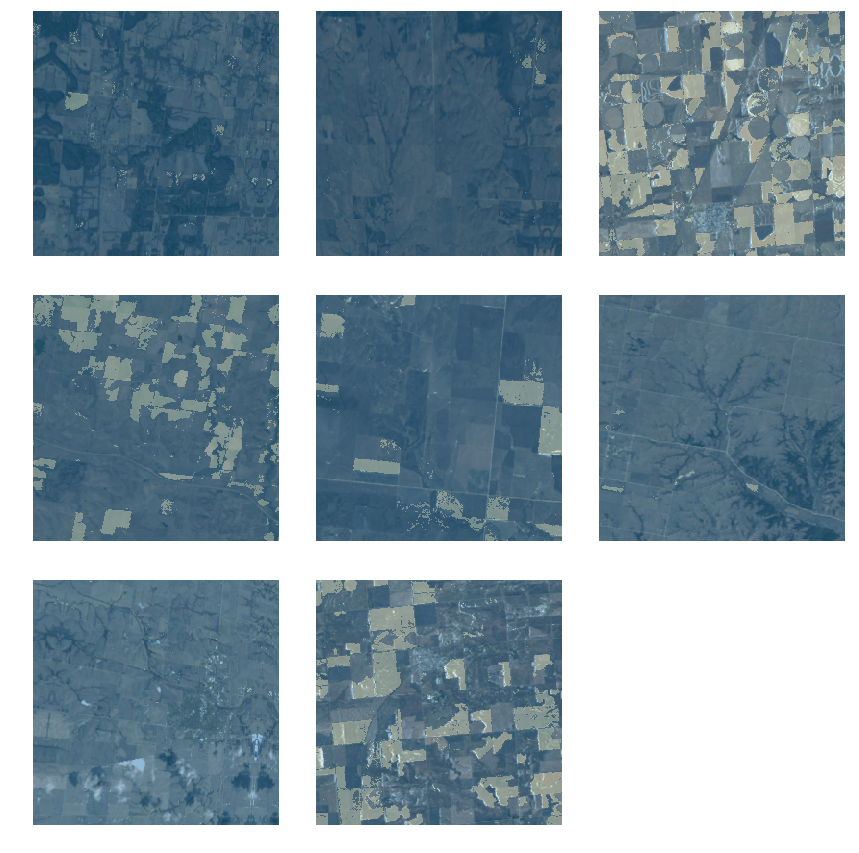

In [20]:
data.show_batch()

In [21]:
def show_single_img_tfms(learn, rows=3, cols=3, figsize=(15, 15)):
    img = learn.data.train_ds.x
    tfms = learn.data.train_ds.tfms
    rand_int = np.random.randint(len(img))
    [img[rand_int].apply_tfms(tfms).show(ax=ax) for i, ax in enumerate(
            plt.subplots(rows, cols, figsize=figsize)[1].flatten())]
    plt.show()
    return learn


Learner.show_single_img_tfms = show_single_img_tfms

In [22]:
crop_codes

['void', 'wheat']

In [23]:
name2id = {v:k for k,v in enumerate(crop_codes)}
void_code = name2id['void']

def acc_crops(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [24]:
metrics=acc_crops
wd=1e-2

In [25]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

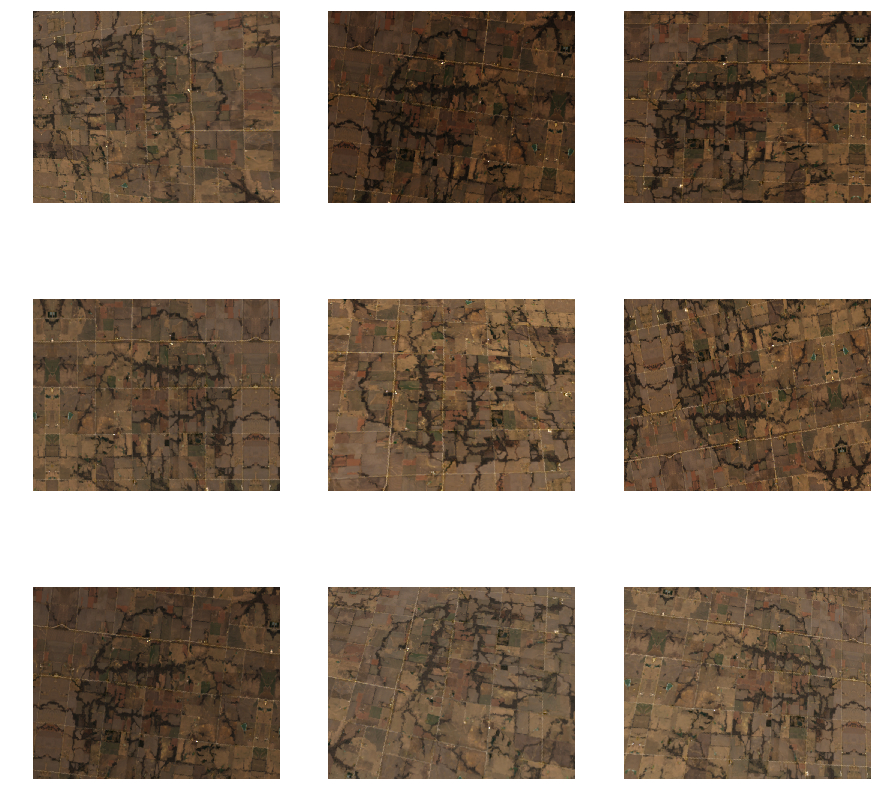

In [27]:
learn.show_single_img_tfms();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


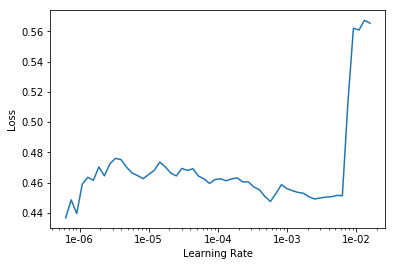

In [28]:
lr_find(learn)
learn.recorder.plot()

In [29]:
lr=5e-4

In [30]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_crops,time
0,0.355053,0.363730,0.406590,02:26
1,0.324984,0.318236,0.399418,02:23
2,0.330897,0.316729,0.342475,02:23
3,0.311869,0.290239,0.343793,02:23
4,0.312222,0.294058,0.421486,02:22
5,0.304309,0.299931,0.393439,02:22
6,0.282506,0.274271,0.399541,02:21
7,0.293829,0.283542,0.462488,02:21
8,0.269812,0.263996,0.457800,02:21
9,0.259501,0.254733,0.493236,02:21


In [31]:
learn.save('wheat-vert-2016-1')

In [32]:
learn.unfreeze()
lrs = slice(lr/100,lr)
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_crops,time
0,0.252080,0.254280,0.489731,02:31
1,0.269029,0.252845,0.445580,02:30
2,0.265086,0.250823,0.517787,02:31
3,0.268107,0.250367,0.472392,02:31
4,0.254709,0.255167,0.503899,02:30
5,0.266198,0.264166,0.497492,02:30
6,0.270599,0.247555,0.490612,02:30
7,0.263845,0.252796,0.481261,02:30
8,0.257069,0.248341,0.475552,02:30
9,0.261386,0.249606,0.549171,02:30


In [33]:
learn.save('wheat-vert-2016-2')

In [26]:
learn=None
gc.collect()


16883

In [27]:
size = (500,500)
bs=4

In [28]:
data = (src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [29]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('wheat-vert-2016-2');


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


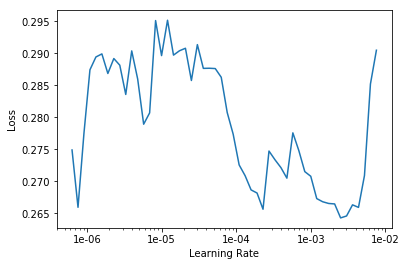

In [30]:
lr_find(learn)
learn.recorder.plot()

In [31]:
lr=1e-4

In [32]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.3)


epoch,train_loss,valid_loss,acc_crops,time
0,0.250417,0.234063,0.550483,09:15
1,0.253607,0.230672,0.555374,09:16
2,0.257378,0.230955,0.567391,09:17
3,0.244673,0.228297,0.520646,09:17
4,0.253936,0.225202,0.530693,09:17
5,0.239296,0.227304,0.507679,09:17
6,0.241894,0.227511,0.568715,09:17
7,0.243729,0.231932,0.602561,09:17
8,0.240441,0.243970,0.536119,09:17
9,0.235497,0.237908,0.563436,09:18


In [35]:
learn.save('big-wheat-vert-2016-1')

In [36]:
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('big-wheat-1');


In [37]:
learn.unfreeze()
lrs = slice(lr/1000,lr/10)
learn.fit_one_cycle(10, lrs, callbacks=[SaveModelCallback(learn,name='big-wheat-vert-2016-2')])

epoch,train_loss,valid_loss,acc_crops,time
0,0.236599,0.220477,0.590297,09:42
1,0.232402,0.220185,0.581934,09:44
2,0.242032,0.235511,0.562734,09:44
3,0.230621,0.221940,0.568533,09:43
4,0.230509,0.232798,0.584803,09:43
5,0.239332,0.221725,0.578807,09:44
6,0.213910,0.219512,0.586733,09:43
7,0.228662,0.225478,0.584713,09:43
8,0.234285,0.219387,0.578447,09:44
9,0.226044,0.219181,0.571489,09:44


Better model found at epoch 0 with val_loss value: 0.22047725319862366.
Better model found at epoch 1 with val_loss value: 0.2201850265264511.
Better model found at epoch 6 with val_loss value: 0.21951192617416382.
Better model found at epoch 8 with val_loss value: 0.21938657760620117.
Better model found at epoch 9 with val_loss value: 0.2191811501979828.


In [38]:
x,y= next(iter(data.valid_dl))

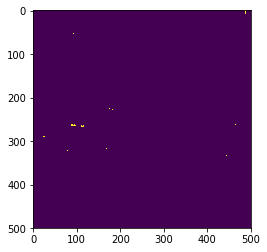

In [39]:
plt.imshow(to_np(y[1])[0])

In [40]:
def overall_acc(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [48]:
learn.validate(metrics=[overall_acc])

[0.25199097, tensor(0.9016)]

In [27]:
learn.validate()

[0.25199097, tensor(0.4794)]

In [34]:
y[0].median()

tensor(0, device='cuda:0')

array([[[0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0]]])

In [45]:
x,y = data.valid_ds[30]

In [46]:
a,b,c = learn.predict(x)

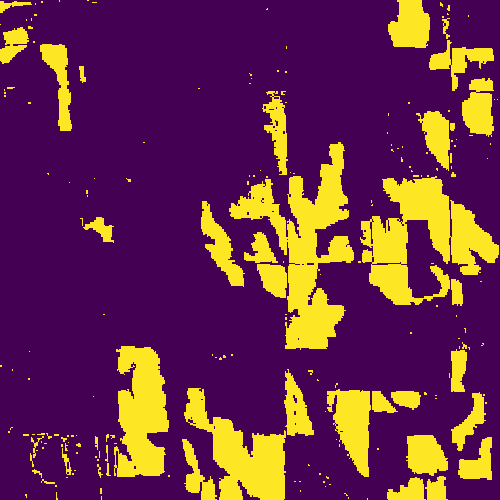

In [47]:
y

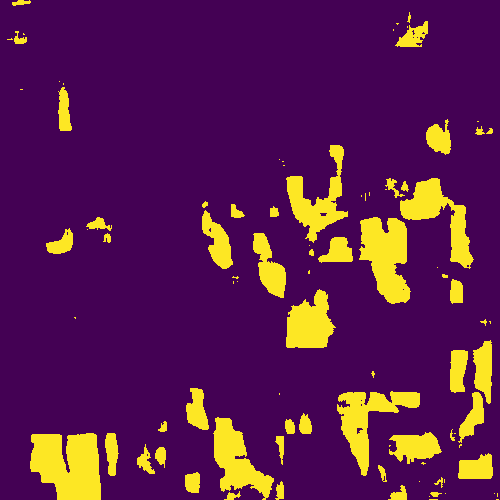

In [48]:
a

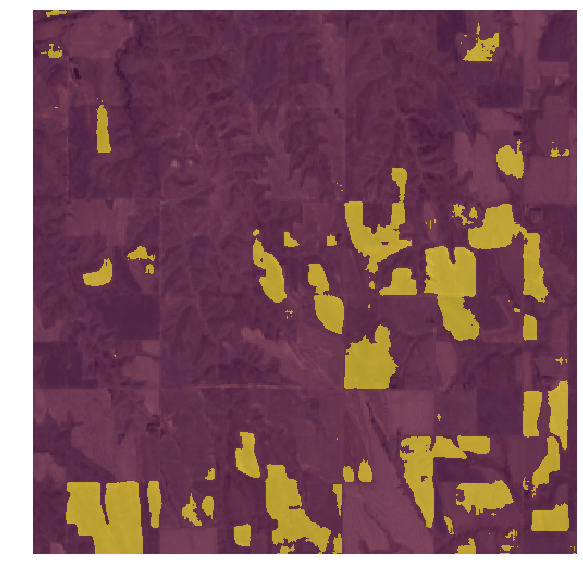

In [49]:
_,ax =plt.subplots(1,1,figsize=(10,10))
x.show(ax=ax)
ax.imshow(c.argmax(0),alpha=0.5)

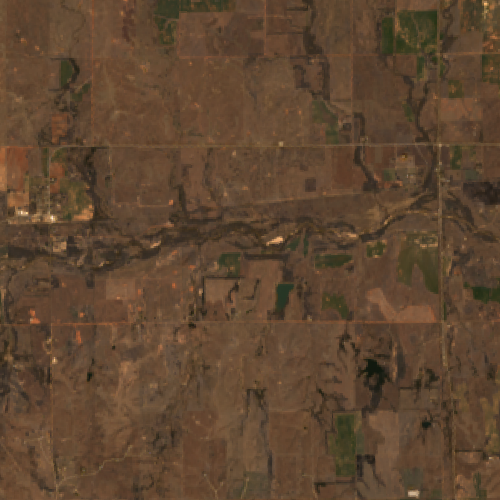

In [105]:
x